# Representations of Networks

Now that you know how to represent networks with matrices, let's take a step back and take a look at what network representation is in general, and the different ways you might think about representing networks to understand different aspects of the network.

We already know that the topological structure of networks is just a collection of nodes, with pairs of nodes potentially linked together by edges. Mathematically, this means that a network is defined by two objects: the set of nodes, and the set of edges, with each edge just being defined as a pair of nodes for undirected networks. Networks can have additional structure: you might have extra information about each node ("features" or "covariates"), which we'll talk about in the joint representation section in [Chapter 6](#link?). Edges might also have weights, which are usually measure the connection strength in some way. We learned in the previous section that network topology can be represented with matrices in a number of ways -- with adjacency matrices, Laplacians, or (less commonly) with incidence matrices. 

One major challenge in working with networks is that a lot of standard mathematical operations and metrics remain undefined. What does it mean to add a network to another network, for instance? How would network multiplication work? How do you define a distance between one node and another node? Without these kinds of basic operations and metrics, you are left in the dark when you try to find analogies to non-network data analysis.

Another major challenge is that the number of possible networks can get obscene fairly quickly. See the figure below, for instance. When you allow for only 50 nodes, there are already more than $10^{350}$ possible networks. Just for reference, if you took all hundred-thousand quadrillion vigintillion atoms in the universe, and then made a new entire universe for each of those atoms... you'd still be nowhere near $10^{350}$ atoms. 

<ipython-input-1-79f80cdec1da>:11: RuntimeWarning: overflow encountered in power
  n_graphs = np.log10(2**comb(vertices, 2))


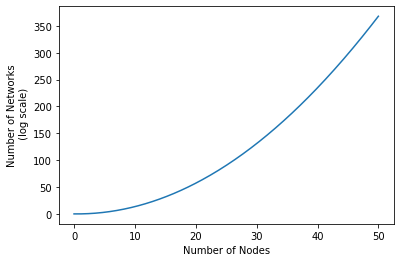

In [1]:
import matplotlib.pyplot as plt
from scipy.special import comb
from contextlib import suppress
from scipy.interpolate import interp1d
import numpy as np

# get number of graphs for a given n in log scale
vertices = np.arange(51, step=10)

with suppress(OverflowError):
    n_graphs = np.log10(2**comb(vertices, 2))
n_graphs[-1] = 368

xnew = np.linspace(vertices.min(), vertices.max(), 300)
interpolated = interp1d(vertices, n_graphs, kind="cubic")
ynew = interpolated(xnew)

# plotting code
fig, ax = plt.subplots()
ax.plot(xnew, ynew)
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Number of Networks\n (log scale)");

To address these challenges, you can generally group analysis into four approaches, each of which addresses these challenges in some way: the bag of features, the bag of edges, the bag of nodes, and the bag of networks, each so-called because you're essentially throwing data into a bag and treating each thing in it as its own object. Let's get into some details!

## Bag of Features
The first approach is called the bag of features. The idea is that you take networks and you compute statistics from them, either for each node or for the entire network. These statistics could be simple things like the edge count or average path length between two nodes, or more complicated metrics like the modularity, which measures how well a network can be separated into communities. Unfortunately, network statistics like this tend to be correlated; the value of one network statistic will almost always influence the other. This means that it can be difficult to interpret analysis that works by comparing network statistics. It's also hard to figure out which statistics to compute, since there are an infinite number of them.

### You Lose A Lot of Information with the Bag of Features Approach

![anascombe](../../Images/anascombe.jpeg)

This figure contains for networks, all of whom have the exact same network statistics. They each have ten nodes and 15 edges. They also all contain the same number of triangles (sets of three nodes which are all connected), and the same global clustering coefficient. Global clustering cloefficient, for reference, gives an indication of how clustered the network is, and works by counting the proportion of triangles out of all edges that share a node.

Each of these networks, however, are completely different from each other. The first network, for instance, has two connected components, while the others are all connected. The second network has a community of nodes that are only connected along a path, and a different community which are tightly connected -- and so on. Modeling these networks through computing features from them would lose a great deal of information.

#### Network Features Tend to be Correlated

The other issue with the bag of features approach is that network features tend to be correlated with each other: if you consider all possible networks, knowing the value of any of the network features gives you information about what the value of other network features might be.

Let's play around with this. We'll make 100 random networks, each with 50 nodes, and then you'll compute some of the most common network features that people use on them (you'll explain what each network feature is along the way). Then, you'll look at how correlated these features are. For now, just think of a random network as being a network with each node being connected to each other node with some set probability. Each network will have a different connection probability. These networks will also have communities -- groups of nodes which are more connected with each other than other nodes -- the strength of which will also be determined randomly. When you generate data later on in this book, you'll get into different types of random network models you can use.

In [2]:
from graspologic.simulations import sbm
import numpy as np
from numpy.random import uniform

n_nodes = 50
n_networks = 100
p = uniform(size=100, low=.5).round(2)
q = uniform(size=100, high=.5).round(2)

networks = []
for i in range(n_networks):
    P = np.array([[p[i], q[i]],
                  [q[i], p[i]]])
    network = sbm(n=[n_nodes//2, n_nodes//2], p=P)
    networks.append(network)

Now, for each of these networks, you'll calculate a set of network features, using some of the various properties you learned about in the previous section on [Properties of Networks](#link?).

The **Modularity** measures the fraction of edges in your network that belong to the same community, subtracting out the probability of an edge existing at random. It effectively measures how much better a particular assignment of community labels is at defining communities than a completely random assignment.

The **Network Density** is the fraction of all possible edges that a network can have which actually exist. If every node were connected to every other node, the network density would be 1; and if no node is connected to anything, the network density would be 0.

The **Clustering Coefficient** indicates how much nodes tend to cluster together. If you pick out three nodes, and two of them are connected, a high clustering coefficient would mean that the third is probably connected as well.

The **Path Length** indicates how far apart two nodes in your network are on average. If two nodes are directly connected, their path length is one. If two nodes are connected through an intermediate node, their path length is two.

The code below defines functions to calculate each of these network features, and then calculates them for each of the networks you created above. Since most of these metrics already exist in `networkx`, you'll just pull from there. You can check the `networkx` documentation for details.

We'll also define a preprocessing decorator, which just converts the network from a numpy array into the format networkx uses.

In [3]:
import functools
import networkx as nx

def preprocess(f):
    @functools.wraps(f)
    def wrapper(network):
        network = nx.from_numpy_matrix(network)
        return f(network)
    return wrapper

@preprocess
def modularity(network):
    communities = nx.algorithms.community.greedy_modularity_communities(network)
    Q = nx.algorithms.community.quality.modularity(network, communities)
    return Q

@preprocess
def network_density(network):
    return nx.density(network)

@preprocess
def clustering_coefficient(network):
    return nx.transitivity(network)

@preprocess
def path_length(network):
    if nx.number_connected_components(network) != 1:
        # You want to make sure this still works if your network isn't fully connected!
        network = max((network.subgraph(c) for c in nx.connected_components(network)), 
                      key=len)
    return nx.average_shortest_path_length(network)

Now, you'll calculate all of these features for each network, and finally you'll create a heatmap of their correlation.

In [4]:
import pandas as pd

network_features = []
for network in networks:
    modularity_ = modularity(network)
    network_density_ = network_density(network)
    clustering_coefficient_ = clustering_coefficient(network)
    path_length_ = path_length(network)
    features = {"Modularity": modularity_, "Network Density": network_density_, 
                "Clustering Coefficient": clustering_coefficient_, "Average Path Length": path_length_}
    network_features.append(features)
    
df = pd.DataFrame(network_features)
feature_correlation = df.corr()

Below is the heatmap. Numbers close to 1 mean that when the first feature is large, the second tends to be large, numbers close to 0 mean that the features are not very correlated, and numbers close to -1 mean that when the first feature is large, the second feature tends to be small.

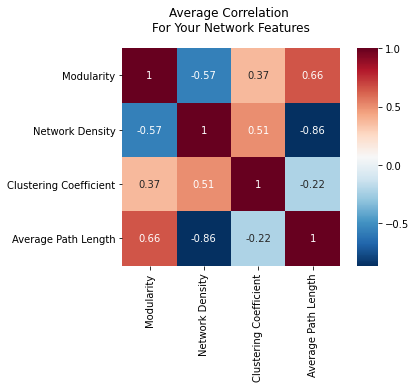

In [5]:
import seaborn as sns
from graphbook_code import cmaps

plot = sns.heatmap(feature_correlation, annot=True, square=True, 
                   cmap=cmaps["divergent"], cbar_kws={"aspect": 10, "ticks": [-1., -.5, 0., 0.5, 1.]})
plot.set_title("Average Correlation \nFor Your Network Features", y=1.05);

If you're familiar with correlation, you'll notice that these correlation numbers generally have a pretty high magnitude: each feature generally tells you a lot about each other feature. Let's explore why this can lead to some issues in practice.

#### Why Network Feature Correlatedness Can Lead To Problems

Let's take a step back to the implications of using the bag of features approach to analyze networks, now that you can see how correlated they usually are. Say you have a bunch of brain networks of mice, where the nodes are neurons and the edges are connections between neurons. You have a group of mice who were raised total darkness, and another group who were raised normally: let's call the ones who were raised in the darkness the batman mice. You're interested in how the visual parts of the brain are affected in the batman mice. You find the networks for only the visual parts of their brain, and then you calculate some network feature; maybe the density. It turns out that the network density is much lower for batman mice than it is for normal mice, so you conclude that raising mice in the darkness causes lower network density. Seems reasonable.

The problem is that network density is correlated with pretty much every other network feature you could have used. For example, just looking at the heatmap above, you can see that it's lower for more modularity; higher with a greater clustering coefficient; and much lower for smaller average path lengths. So, for instance, if you measured modularity instead of density, then you could have just as easily concluded that raising mice in total darkness causes their brains to have more well-defined clusters of neurons, and you'd then write an entire paper on the implications of that.

## Bag of Edges

The second approach is called the bag of edges. Here, you just take all of the edges in your network and treat them all as independent entities. You study each edge individually, ignoring any interactions between edges. This can work in some situations, but you still run into dependence: if two people within a friend group are friends, that can change the dynamic of the friend group and so change the chance that a different set of two people within the group are friends.

More specifically, in the bag of edges approach, you generally assume that every edge in your network will exist with some particular *probability*, which can be different depending on the edge that you're looking at. For example, there might be a 60% chance that the first and second nodes in your network are connected, but only a 20% chance that the third and fourth nodes are. What often will happen here is that you have multiple networks describing the same (or similar) systems. For example, let's use the mouse example again from above. You have your batman mice (who were raised in the dark) and your normal mice. You'll have a network for each batman mouse and a network for each normal mouse, and you assume that, even though there's a bit of variation in what you actually see, the *probability* of an edge existing between the same two nodes is the same for all batman mice. Your goal would be to figure out which edges have a different *probability* of existing with the batman mice compared to the normal mice.

Let's make some example networks to explore this. We'll have two groups of networks, and all of the networks will have only three nodes for simplicity's sake. Each group will contain 20 networks, for a total of 40 networks. In the first group, every edge between every pair of nodes simply has a 50% chance of existing. In the second group, the edge between nodes 0 and 1 will instead have a 90% chance of existing, but every other edge will still just be 50%. We'll generate ten networks from the first group, and ten networks from the second group.

In [6]:
from graspologic.simulations import sample_edges

P1 = np.array([[.5, .5, .5],
               [.5, .5, .5],
               [.5, .5, .5]])

P2 = np.array([[.5, .9, .5],
               [.9, .5, .5],
               [.5, .5, .5]])

# First group
n_networks = 20
first_group = np.empty((n_networks, 3, 3))
for i in range(n_networks):
    network = sample_edges(P1)
    first_group[i] = network
    
# Second group
second_group = np.empty((n_networks, 3, 3))
for i in range(n_networks):
    network = sample_edges(P2)
    second_group[i] = network

### Figuring out which edge is the outlier

By design, you know that the edge between nodes 0 and 1 is an outlier - the probability that it's there changes depending on whether your network is in the first or the second group. One common goal when using the bag of edges approach is finding signal edges: an edge whose probability of existing changes depending on which type of network you're looking at. In your case, we're trying to figure out (without using your prior knowledge) that the edge between nodes 0 and 1 is a signal edge.

To find the outlier edge, you'll first get the set of all edges, along with their indices. Since all of your networks are undirected, you'll get the edges and their indices by finding all of the values in the the upper-triangular portion of the adjacency matrices.

In [7]:
edge_indices = np.triu_indices(3, k=1)

Now, you'll use a hypothesis test called *dcorr* to find the outlier edge. You don't need to worry too much about what dcorr is; it's essentially a hypothesis that is useful with networks, which doesn't make any assumptions about the relationships between edges or the way your networks were randomly generated. 

In the code below, we:
1. Loop through the edge indices
2. Get a list of all instances of that edge in the first group, and all instances of that edge in the second group
3. Feed that list into the dcorr test to obtain p-values for each edge

In [8]:
from hyppo.ksample import KSample

edge_pvals = []
for i, j in zip(*edge_indices):
    samples = [group[:, i, j] for group in [first_group, second_group]]
    _, pvalue = KSample("Dcorr").test(*samples)
    edge_pvals.append(pvalue)

You can see below that the p-value for the first edge, the one that connects nodes 0 and 1, is extremely small, whereas the p-values for the other two edges are relatively large.

In [9]:
np.array(edge_pvals).round(3)

array([0.003, 0.35 , 1.   ])

#### Correcting for Multiple Comparisons

Because you are doing multiple tests, we're running into a multiple comparisons problem here. If you're not familiar with the idea of multiple comparisons in statistics, it is as follows. Suppose you have a test that estimates the probability of making a discovery (or, to be more rigorous, tells you whether you should reject the idea that you didn't make a discovery). You run that test multiple times. If you run this test enough times, even if there's no discovery to be made, eventually random chance will make it *seem* like you've made a discovery. So, the chance that you make a false discovery increases with the number of tests that you run. For example, say your test has a 5% false-positive rate, and you run this test 100 times. On average, there will be 5 false positives. If there was only one true positive in all of your data, and your test finds it, then you'll end up with 6 positives total, 5 of which were false.

We need to correct for this here because we're doing a new test for each edge. There are a few standard ways to do this, but you'll use something called the *Holm-Bonferroni correction*. Don't worry about the details of this; all you need to know for now is that it corrects for the multiple comparisons problem by being a bit more conservative with what you classify as a positive result. This correction is implemented in the `statsmodels` library, a popular library for statistical tests and data exploration.

In [10]:
from statsmodels.stats.multitest import multipletests

reject, corrected_pvals, *_ = multipletests(edge_pvals, method="holm", alpha=0.05)

You can see below that the corrected p-value for the edge connecting nodes 0 and 1 is still extremely small. We somewhat arbitrarily chose a value of .05 as the cutoff for determining an outlier, so you can say that any edge with a corrected p-value below .05 is an outlier edge. We've used the bag-of-edges approach to find an edge whose probability of existing changed depending on which group a network belongs to!

In [11]:
corrected_pvals.round(3)

array([0.008, 0.7  , 1.   ])

## Bag of Nodes

Similarly to the bag of edges, you can treat all of the nodes as their own entity and do analysis on a bag of nodes. Much of this book will focus on the bag of nodes approach, because you'll often use edge count, covariate information, and other things when you work with bags of nodes -- and, although there's still dependence between nodes, it generally isn't as big of an issue. Most of the single-network methods you'll use in this book will take the bag of nodes approach. What you'll see repeatedly is that you take the nodes of a network and *embed* them so each node is associated with a point on a plot (this is called the Euclidean representation of the node). Then, you can use other methods from mainstream machine learning to learn about your network. We'll get into this heavily in future chapters.

We'll also often associate node representation with community investigation. The idea is that sometimes you have groups of nodes which behave similarly -- maybe they have a higher chance of being connected to each other, or maybe they're all connected to certain other groups of nodes. Regardless of how you define communities, a community investigation motif will pop up: you get your node representation, then you associate nearby nodes to the same community. We can then look at the properties of the node belonging to a particular community, or look at relationships between communities of nodes.

Since you'll use the bag of nodes approach heavily throughout this book, you'll be getting a much better sense for what you can do with it later. As a sneak preview right now, let's generate a few networks and embed their nodes to get a feel for what bag-of-nodes type analysis might look like.

Don't worry about the specifics, but below you generate a simple network with two communities. Nodes in the same community have an 80% chance of being connected, whereas nodes in separate communities have a 20% chance of being connected. There are 20 nodes per community.

In [12]:
from graspologic.simulations import sbm

# generate network
P = np.array([[.8, .2,],
              [.2, .8]])
network, labels = sbm(p=P, n=[20, 20], return_labels=True)

Now, you'll use graspologic to find the points in 2D space that each node is associated with. Again, don't worry about the specifics: this will be heavily explained later in the book. All you have to know right now is that we're moving the nodes of your network from network space, where each node is associated with a set of edges with other nodes, to 2D Euclidean space, where each node is associated with an x-coordinate and a y-coordinate.

In [13]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

ase = ASE(n_components=2)
embedding = ase.fit_transform(network)

Below you can see the result, colored by community. Each of the dots in this plot is one of the nodes of your network. You can see that the nodes cluster into two groups: one group for the first community, and another group for the second community. Using this representation for the nodes of your network, you can open the door to later downstream machine learning tasks.

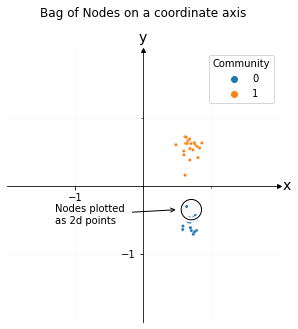

In [14]:
from graphbook_code import plot_latents, draw_cartesian, add_circle, text

ax = draw_cartesian(xrange=(-1, 1), yrange=(-1, 1))
plot = plot_latents(embedding, labels=labels, ax=ax)
plot.set_title("Bag of Nodes on a coordinate axis", y=1.1);

# plot circle
x_centroid, y_centroid = embedding[labels==0].mean(axis=0)
add_circle(x_centroid, y_centroid+.2, ax=ax)
ax.annotate("Nodes plotted \nas 2d points", xy=(x_centroid-.2, y_centroid+.2), xytext=(x_centroid-2, y_centroid), 
            arrowprops={"arrowstyle": "->"});

## Bag of Networks

The last approach is the bag of networks, which you'd use when you have more than one network that you're working with. Here, you'd study the networks as a whole and you'd want to test for differences across different networks or classify entire networks into one category or another. You might want to figure out if two networks were drawn from the same probability distribution, or whether you can find a smaller group of nodes that can represent the whole network, preserving its important properties. This is can be useful if you have extremely large networks, with millions of nodes.

To showcase the bag of networks approach, let's create a few networks. We'll have one group of networks distributed the same way, and another group distributed differently. What you want to do is plot each network as a point in space, so that you can see the communities of networks directly.

Both sets of networks will have two communities of nodes, but the first set will have slightly stronger within-community connections than the second. Each network will have 200 nodes in it, 100 for each community.

In [15]:
def make_network(*probs, n=100, return_labels=False):
    pa, pb, pc, pd = probs
    P = np.array([[pa, pb], 
                  [pc, pd]])
    
    return sbm([n, n], P, return_labels=return_labels)

n = 100
p1, p2, p3 = .12, .06, .03

first_group = []
for _ in range(6):
    network = make_network(p1, p3, p3, p1)
    first_group.append(network)
    
second_group = []
for _ in range(12):
    network = make_network(p2, p3, p3, p2)
    second_group.append(network)

Again, don't worry too much yet about the process with which these networks were generated - that will all be explained in the next few chapters. All you need to get out of this code is that you have six networks from the first group, and another twelve networks from the second. You can see these networks in heatmap form below.

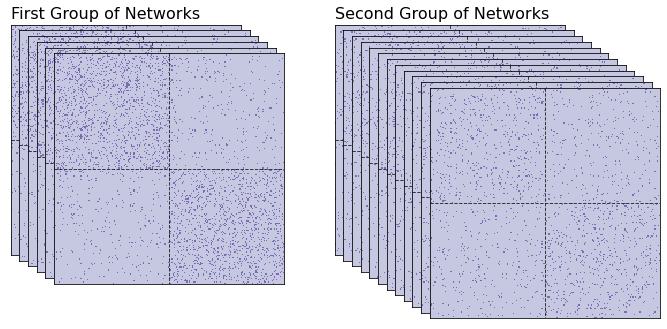

In [16]:
from graphbook_code import heatmap

fig = plt.figure();

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

# add stack of heatmaps
for i in range(6):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = heatmap(first_group[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("First Group of Networks", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
# add stack of heatmaps
for i in range(12):
    ax = fig.add_axes([.02*i+.75, -.02*i, .8, .8]) 
    ax = heatmap(second_group[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Second Group of Networks", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

Now, you have to figure out some way of plotting each network as a point in space. Here's a rough overview for how you'll do it.

First, you'll take all of your networks and get a Euclidean location for each of their nodes. The nodes for all of the networks will exist in the same space, meaning their locations can be compared with each other. We'll have a bunch of matrices, one for each network. Since each network has 200 nodes, and we're embedding into 2-dimensional space, you'll have six 200 by 2 matrices for the first group of networks, and another twelve 200 by 2 matrices for the second group.

Now, you'll look at pairwise dissimilarity for each matrix. The dissimilarity between the $i_{th}$ and $j_{th}$ network is defined as the norm of the difference between the $i_{th}$ matrix and the $j_{th}$ matrix that we've created this way. You can think of this pairwise dissimilarity as just a number that tells you how different the representations for the nodes are between the two networks: a low number means the networks have very similar nodes, and a high number means the networks have very different nodes.

Then, you'll organize all of these pairwise dissimilarities into a dissimilarity *matrix*, where the $i, j_{th}$ entry is the dissimilarity between the $i_{th}$ and $j_{th}$ network. Embedding this *new* matrix will give us a point in space for each network.

Again, don't worry if you don't understand the details: embedding and how it works will be explained in future chapters.

In [17]:
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed import ClassicalMDS

# Find a euclidean location for the nodes of all of your networks
omni = OMNI(n_components=2)
omni_embedding = omni.fit_transform(first_group + second_group)

# embed each network representation into a 2-dimensional space
cmds = ClassicalMDS(2)
cmds_embedding = cmds.fit_transform(omni_embedding)

# Find and normalize the dissimilarity matrix
distance_matrix = cmds.dissimilarity_matrix_ / np.max(cmds.dissimilarity_matrix_)

You can see the dissimilarity matrix below, with values between 0 and 1 since you normalized it. As you can see, there are two groups, with the values for two networks in different groups having high dissimilarity, and the values for two networks in the same group having low dissimilarity. The diagonals of the matrix are all 0, because the dissimilarity between a network and itself is 0.

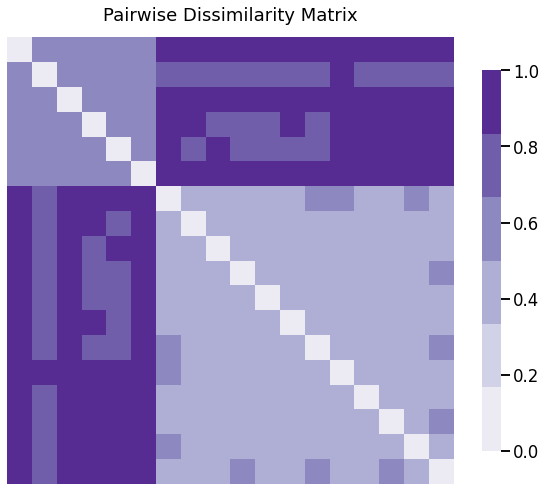

In [18]:
heatmap(distance_matrix, title="Pairwise Dissimilarity Matrix");

Once you find the embedding for this dissimilarity matrix, you can plot each of the networks in space. In the plot below, each network represents a single point in space. We can easily see the two clusters, which represent the two types of networks you created. Since there are six networks of the first type and twelve of the second type, one of the clusters has six dots, and the other has twelve dots.

Text(0.5, 1.1, 'Different groups of networks')

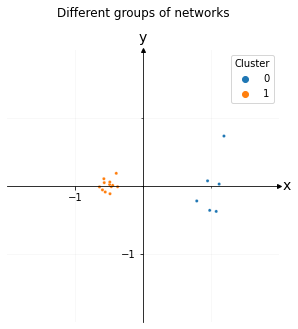

In [20]:
labels = [0]*6 + [1]*12
ax = draw_cartesian(xrange=(-1, 1), yrange=(-1, 1))
plot = plot_latents(cmds_embedding, ax=ax, labels=labels)
plot.legend_.set_title("Cluster")
plot.set_title("Different groups of networks", y=1.1)